Conditional Inference on MNIST Dataset
===

In [1]:
model_comparison = dict()

## Packages

In [2]:
import copy
from utils.supports import *
from tensorflow.examples.tutorials.mnist import input_data
from tqdm import tqdm
from models.vae import VAE
from utils.codings import fc_mnist_encoder, fc_mnist_decoder
from utils.plot import *
import re
import numpy as np
import tensorflow as tf
from scipy.stats import bernoulli
from scipy.stats import norm
from tensorflow.contrib.distributions import Normal

import matplotlib.pyplot as plt
import seaborn as sns

## Global Constants

In [3]:
LATENT_DIM = 2
OBS_DIM = 784
BATCH_SIZE = 128
ENCODER = fc_mnist_encoder
DECODER = fc_mnist_decoder
WEIGHTS = 'weights/generator.tensorflow'
MNIST = 'data/mnist'
MASKED_DATA_SIZE = 5
MASKED_DATA_DROPOUT = [0.95, 0.85, 0.75]

## Conditional Inference Data

In [4]:
def get_masked_mnist(datasize, random_mask=False, dropout=0.9):

    provider = input_data.read_data_sets(train_dir=MNIST)
    x, _ = provider.test.next_batch(datasize)
    x = x.reshape([datasize, 1, -1])

    if random_mask:
        if isinstance(dropout, float):
            mask = np.array([bernoulli.rvs(1-dropout, size=28*28)]*datasize)
            mask = mask.reshape([datasize, 28 * 28])
        else:
            output = []
            output.append(x)
            for opt in dropout:
                mask = np.array([bernoulli.rvs(1-opt, size=28*28)]*datasize)
                output.append(mask.reshape([datasize, 1, -1]))
                
            return np.concatenate(output, axis=1)
                
                
    else:
        mask = np.ones([datasize, 28, 28])
        mask[:, 14:] = 0
        mask[:, :, :14] = 0
        mask = mask.reshape([datasize, 28*28])

    mask = mask.reshape([datasize, 1, -1])
    return np.concatenate((x,mask), axis=1)

In [292]:
data = get_masked_mnist(MASKED_DATA_SIZE,random_mask=True, dropout=MASKED_DATA_DROPOUT)

Extracting data/mnist/train-images-idx3-ubyte.gz
Extracting data/mnist/train-labels-idx1-ubyte.gz
Extracting data/mnist/t10k-images-idx3-ubyte.gz
Extracting data/mnist/t10k-labels-idx1-ubyte.gz


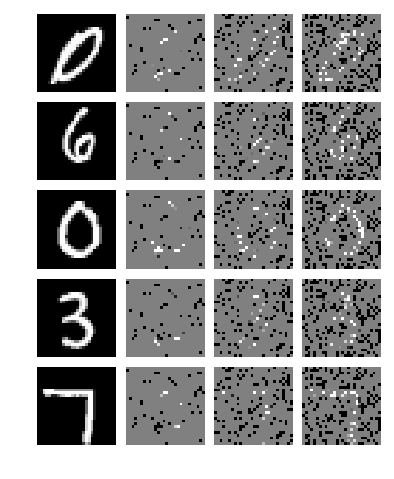

In [293]:
images = []
for i in data:
    images.append(i[0])
    images.append(i[0]*i[1]+0.5*(1-i[1]))
    images.append(i[0]*i[2]+0.5*(1-i[2]))
    images.append(i[0]*i[3]+0.5*(1-i[3]))
show_mnist2(images, MASKED_DATA_SIZE, len(MASKED_DATA_DROPOUT)+1, save=False, noise=False)

## Train VAE Model for MNIST dataset

In [294]:
def train_vae(epochs, iteration):
    history = []
    kwargs = {
        'latent_dim': LATENT_DIM,
        'batch_size': BATCH_SIZE,
        'encoder': ENCODER,
        'decoder': DECODER
    }
    vae = VAE(**kwargs)
    provider = input_data.read_data_sets(train_dir=MNIST)

    tbar = tqdm(range(epochs))
    for epoch in tbar:
        training_loss = 0.

        # iterate through batches
        for _ in range(iteration):
            x, _ = provider.train.next_batch(kwargs['batch_size'])
            loss = vae.update(x)
            training_loss += loss

        # average loss over most recent epoch
        training_loss /= (iteration)
        # update progress bar
        s = "Loss: {:.4f}".format(training_loss)
        history.append(training_loss)
        tbar.set_description(s)
    vae.save_generator(WEIGHTS)
    
    return history

In [295]:
#vae_history = train_vae(1000, 100)

In [296]:
# fig,ax = plt.subplots(1, 1, figsize=(6, 4))
# ax.plot(vae_history)
# ax.set_title('Training Loss')
# fig.tight_layout()
# plt.show()

## Generator

In [297]:
class GENERATOR(object):

    def __init__(self, latent_dim, observation_dim, generator,
                 obs_distrib="Bernoulli",
                 obs_std=0.1,
                 ):
        """

        """
        self._latent_dim = latent_dim
        self._observation_dim = observation_dim
        self._generator = generator
        self._obs_distrib = obs_distrib
        self._obs_std = obs_std
        self._p_distribution = self._multivariate_normal()
        self._build_graph()

    def _multivariate_normal(self):
        return Normal([0.] * self._latent_dim, [1.] * self._latent_dim)

    def _build_graph(self):

        with tf.variable_scope('is'):
            # placeholder for the input noise
            self.candid = tf.placeholder(tf.float32, shape=[None, self._latent_dim], name='candidate')

            self.partialx = tf.placeholder(tf.float32, shape=[None, self._observation_dim], name='partialx')
            self.mask = tf.placeholder(tf.float32, shape=[self._observation_dim], name='mask')

            # decode batch
            with tf.variable_scope('generator'):
                    self.generated, _ = self._generator(self.candid, self._latent_dim)

            if self._obs_distrib == "Gaussian":
                with tf.variable_scope('gaussian'):
                    log_like = self._gaussian_log_likelihood(self.partialx * self.mask,
                                                             self.generated * self.mask,
                                                             self._obs_std)
            else:
                with tf.variable_scope('bernoulli'):
                    log_like = self._bernoulli_log_likelihood(self.partialx * self.mask,
                                                              self.generated * self.mask)
                    
                self.log_like = log_like-tf.reduce_sum(tf.log(self._p_distribution.prob(self.candid)), axis=1)
                self.probs = tf.exp(-self.log_like)

            with tf.variable_scope('gradient'):
                self.gradient = tf.gradients(tf.reduce_sum(self.log_like), self.candid)

            self._sesh = tf.Session()
            init = tf.global_variables_initializer()
            self._sesh.run(init)

    def load_pretrained(self, path):
        generator_variables = []
        for v in tf.trainable_variables():
            if "generator" in v.name:
                generator_variables.append(v)
        saver = tf.train.Saver(generator_variables)
        saver.restore(self._sesh, path)

    def e2x(self, noise):
        x = self._sesh.run(self.generated,
                           feed_dict={self.candid: noise})
        return x

    @staticmethod
    def _gaussian_log_likelihood(targets, mean, std):
        se = 0.5 * tf.reduce_sum(tf.square(targets - mean), axis=1) / (2 * tf.square(std))
        return se


    @staticmethod
    def _bernoulli_log_likelihood(targets, outputs, eps=1e-8):
        log_like = -tf.reduce_sum(targets * tf.log(outputs + eps)
                                  + (1. - targets) * tf.log((1. - outputs) + eps), axis=1)
        return log_like
    
    def get_density(self, candid, partialx, mask):
        density = self._sesh.run(self.probs,
                                 feed_dict={self.candid: candid, self.partialx: partialx, self.mask: mask})
        return density

    def get_log_density(self, candid, partialx, mask):
        log_like = self._sesh.run(self.log_like,
                                  feed_dict={self.candid: candid, self.partialx: partialx, self.mask: mask})
        return log_like

    def get_gradient(self, candid, partialx, mask):
        gradient = self._sesh.run(self.gradient, feed_dict={self.candid:candid, self.partialx:partialx, self.mask: mask})
        return np.asarray(gradient)[0]

In [298]:
tf.reset_default_graph()
g = GENERATOR(LATENT_DIM, OBS_DIM, DECODER)
g.load_pretrained(WEIGHTS)

INFO:tensorflow:Restoring parameters from weights/generator.tensorflow


INFO:tensorflow:Restoring parameters from weights/generator.tensorflow


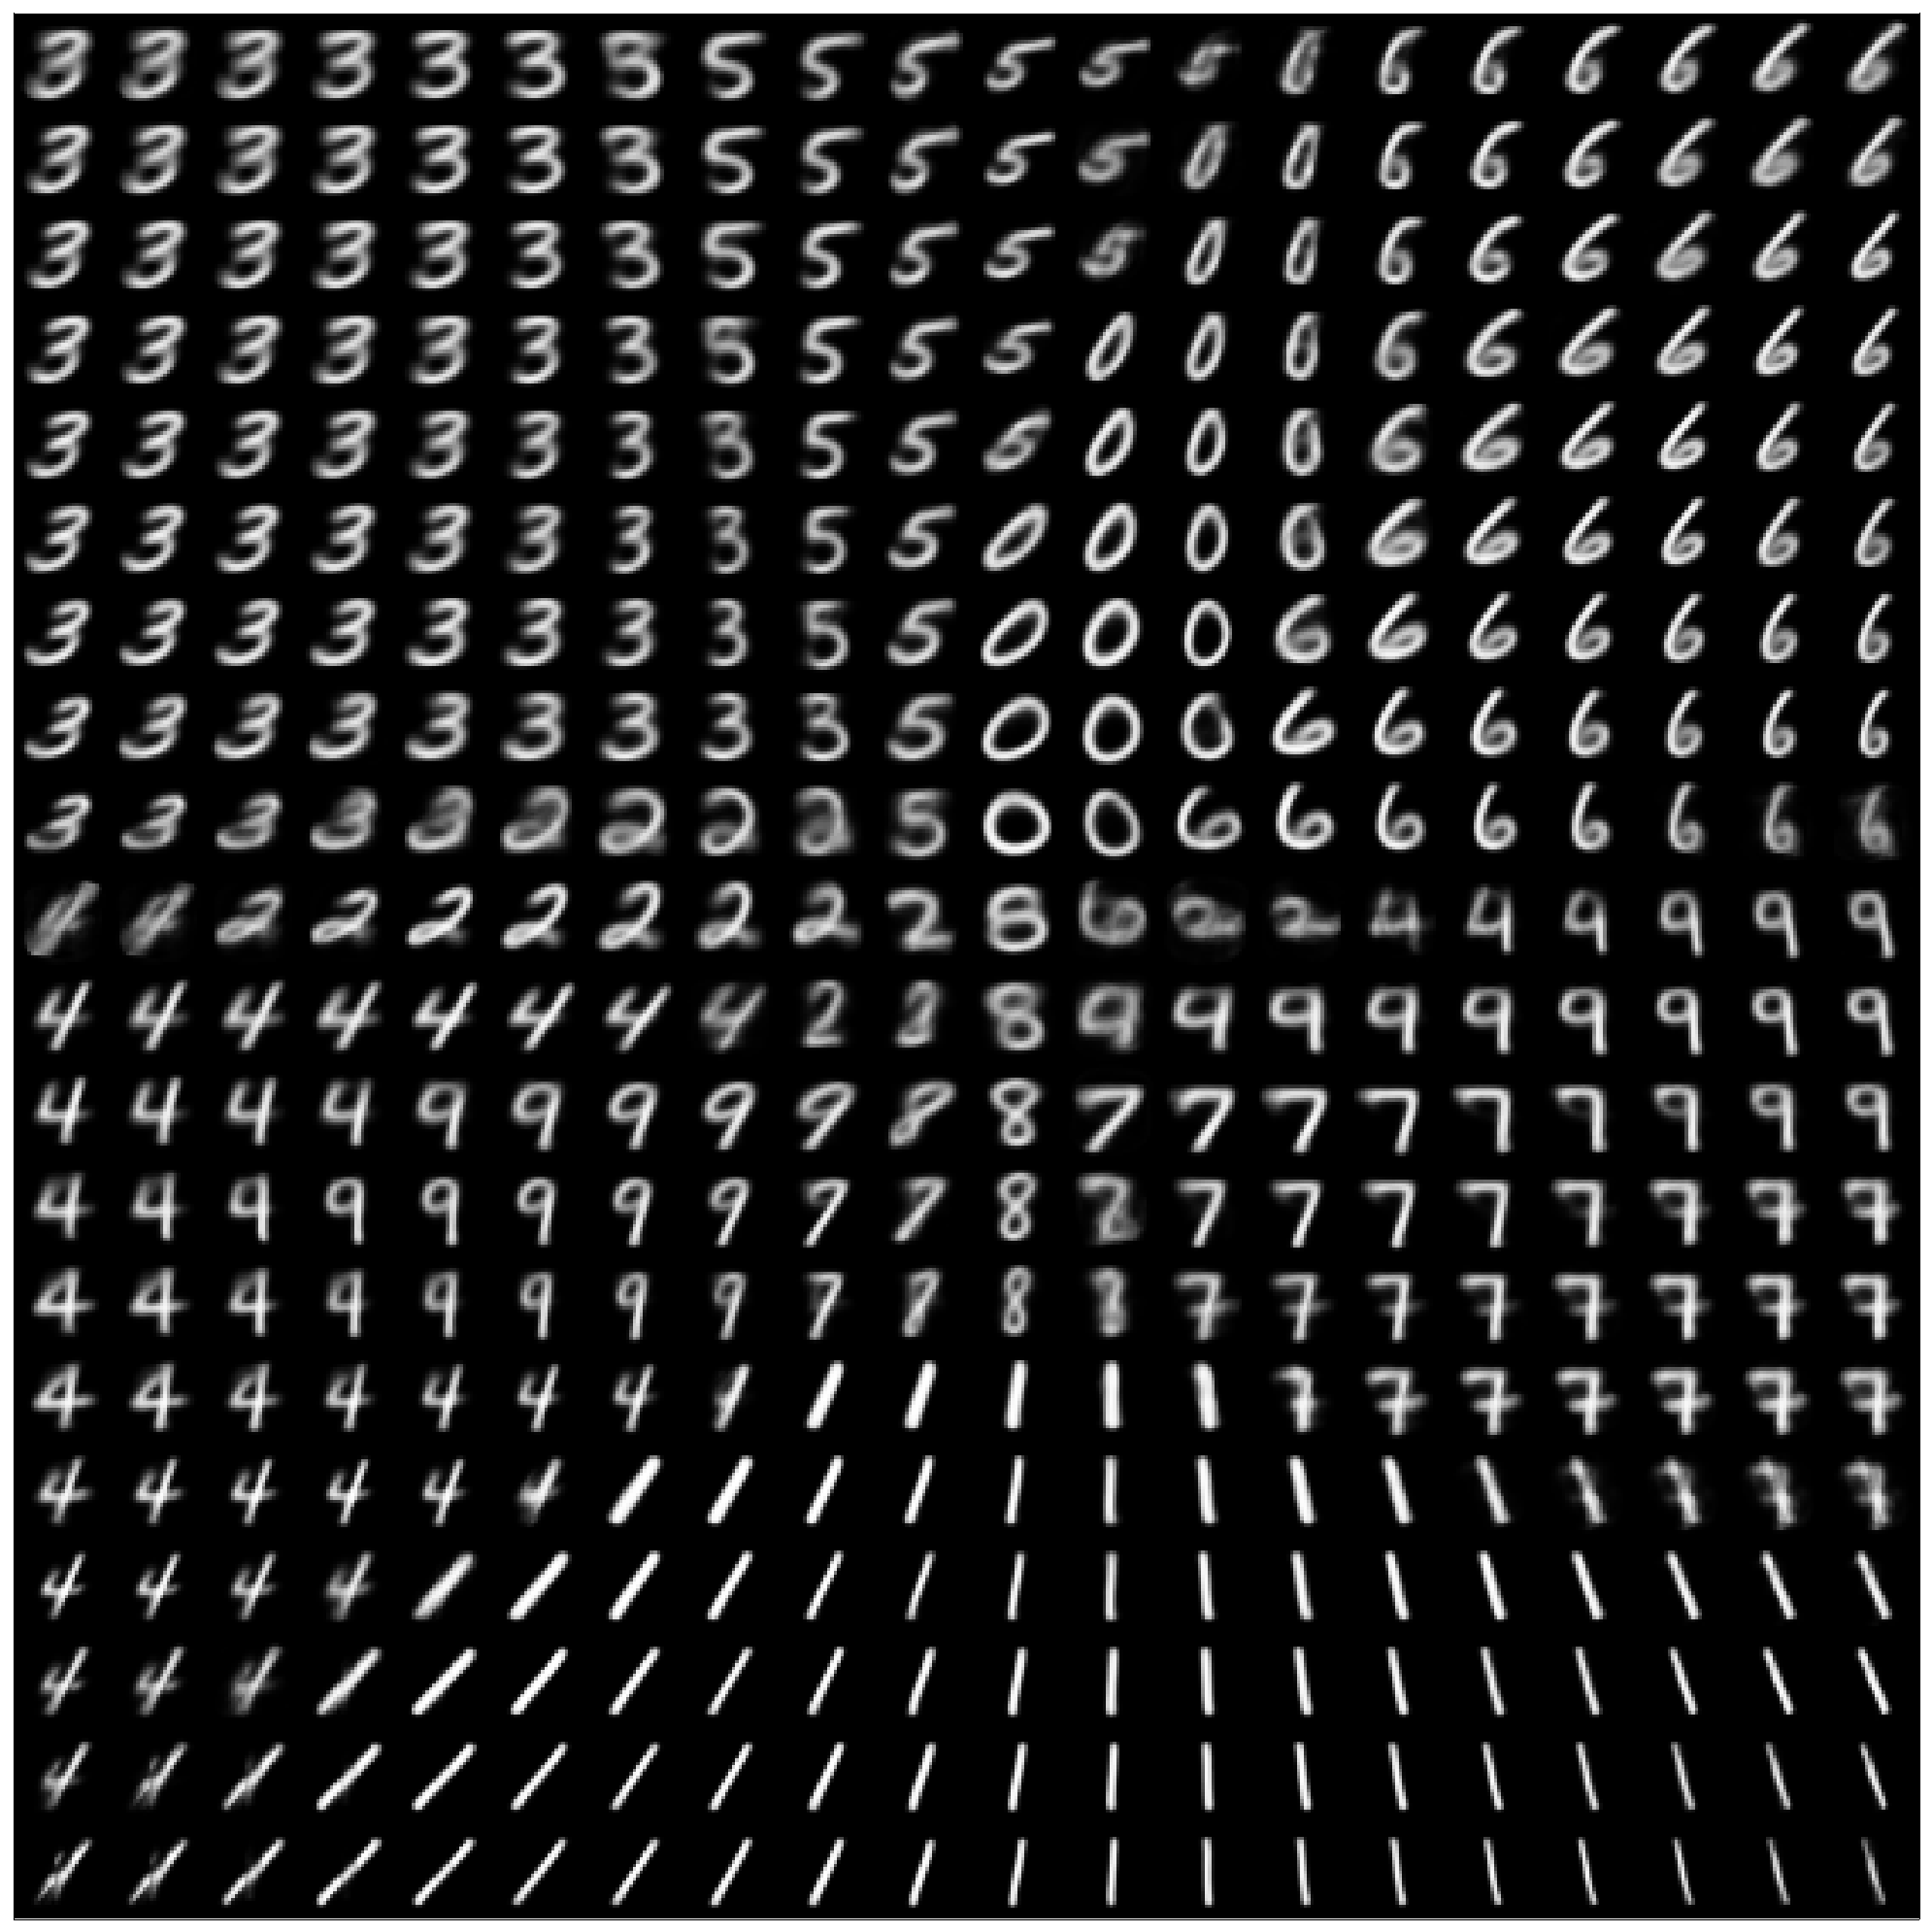

In [299]:
show_vae_samples(g, 20)

In [1]:
plt.clf()
fig,ax = plt.subplots(2, MASKED_DATA_SIZE, figsize=(20, 8))
xs = arange(-4,4,.1)
x1,x2 = meshgrid(xs,xs)
obs = []
for i in range(x1.shape[0]):
    for j in range(x1.shape[1]):
        obs.append([x1[i,j],x2[i,j]]) 
for i in range(MASKED_DATA_SIZE):
    P = g.get_density(obs,np.repeat([data[i][0]], len(obs), axis=0),data[i][1])
    P = P.reshape(len(xs),len(xs))
    ax[0,i].contour(x1,x2,P,30)
    P = g.get_log_density(obs,np.repeat([data[i][0]], len(obs), axis=0),data[i][1])
    P = P.reshape(len(xs),len(xs))
    ax[1,i].contour(x1,x2,P,30)
plt.show()

In [301]:
DATA_OF_INTEREST = 3

In [398]:
def plotquery(images, mask, save=True, name='query_mnist', folder='samples', noise=True, exception=[]):
    col = 2
    row = 2
    fig = plt.figure(figsize=(col*2.5, row*2.5))
    grid = ImageGrid(fig, 111,
                     nrows_ncols=(row, col),
                     axes_pad=0.5)
    
    names = ['(x,y)','y', '','x']
    num_images = len(names)
    for i in xrange(num_images):
        if noise == True and (i not in exception):
            im = images[i]
            if i == 3:
                positive = (im*mask).astype(bool).reshape(28,28)
                negative = ((1-im)*mask).astype(bool).reshape(28,28)
            im = im.reshape(28, 28)
            im = np.repeat(im[:, :, np.newaxis], 3, axis=2)
            if i == 3:
                im[:,:,0][positive] = 1.0
                im[:,:,1][positive] = 0.6
                im[:,:,2][positive] = 0.2
                im[:,:,0][negative] = 0.0
                im[:,:,1][negative] = 0.0
                im[:,:,2][negative] = 0.7
        else:
            pass
            im = images[i].reshape(28, 28)
        axis = grid[i]
        axis.axis('off')
        if i != 2:
            axis.imshow(im,vmin=0, vmax=1)
            axis.set_title(names[i], fontsize=20)
    plt.axis('off')
    plt.tight_layout()
    if save:
        fig.savefig('figs/samples/query_mnist.pdf', bbox_inches="tight", 
                    pad_inches=0, format='pdf')
    else:
        plt.show()

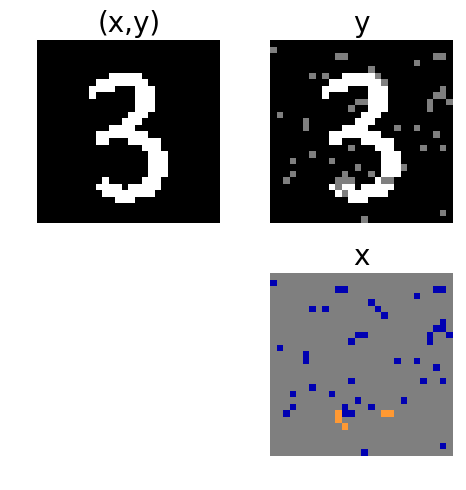

In [399]:
images = []
im = data[DATA_OF_INTEREST][0]
im[im < 0.5] = 0
im[im >= 0.5] = 1
images.append(im)
images.append(im*(1-data[DATA_OF_INTEREST][1])+0.5*data[DATA_OF_INTEREST][1])
images.append(np.ones(784))

images.append(im*data[DATA_OF_INTEREST][1]+0.5*(1-data[DATA_OF_INTEREST][1]))
plotquery(images, data[DATA_OF_INTEREST][1], save=False, name='query_mnist', folder='samples')

In [304]:
not(0 in [1,2])

True

## Reject Sampling

In [305]:
class RejectionSampling(object):
    def __init__(self, generator, evidence, mask, batch_size, latent_dim):
        self.generator = generator
        self.evidence = evidence
        self.mask = mask
        self.dim = latent_dim
        self.batch_size = batch_size
        self.M = self.compute_M()
        
    def compute_M(self):
        x = np.random.normal(0, 1, size=[100000, self.dim])
        px = self.generator.get_density(x, self.evidence, self.mask)
        qx = multivariate_normal.pdf(x, mean=[0]*self.dim, cov=np.eye(self.dim))
        return max(px/qx)
        
    def sampler(self):
        x = np.random.normal(0, 1, size=[self.batch_size, self.dim])
        px = self.generator.get_density(x, self.evidence, self.mask)
        qx = multivariate_normal.pdf(x, mean=[0]*self.dim, cov=np.eye(self.dim))
        
        rate = np.random.random_sample(size=self.batch_size)
        cond = rate < px/(qx*self.M)
        accepted_x = np.array([xv for (c,xv) in zip(cond,x) if c])
        
        violation = px/(qx*self.M) > 1
        
        return accepted_x, cond, violation
    
    def gather_samples(self, size):
        accept = []
        violation = []
        samples = []
        
        for i in tqdm(range(size)):
            q, accept_rate, violation_rate = self.sampler()
            samples.append(q)
            accept.append(accept_rate)
            violation.append(violation_rate)

        return np.vstack(samples), np.average(accept), np.average(violation)

In [306]:
rs = RejectionSampling(g, np.repeat([data[DATA_OF_INTEREST][0]], 1, axis=0), data[DATA_OF_INTEREST][1], 30000, 2)

In [307]:
print(rs.M)

0.001279557578344731


In [308]:
rs_samples, accept_rate, violation_rate = rs.gather_samples(1)

100%|██████████| 1/1 [00:00<00:00, 19.86it/s]


In [309]:
accept_rate

0.019

In [310]:
violation_rate/accept_rate

0.0

In [311]:
rs_samples.shape

(570, 2)

In [312]:
model_comparison['True'] = [g.get_density(obs,np.repeat([data[DATA_OF_INTEREST][0]], len(obs), axis=0),
                                          data[DATA_OF_INTEREST][1]), rs_samples]

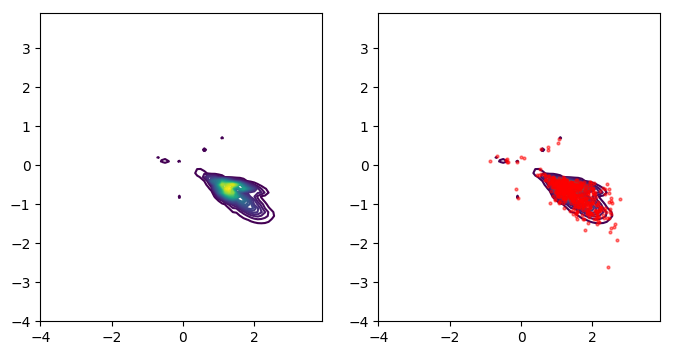

In [313]:
plt.clf()
fig,ax = plt.subplots(1, 2, figsize=(8, 4))
P = g.get_density(obs,np.repeat([data[DATA_OF_INTEREST][0]], len(obs), axis=0),data[DATA_OF_INTEREST][1])
P = P.reshape(len(xs),len(xs))
ax[0].contour(x1,x2,P,30)
ax[1].contour(x1,x2,P,30)
ax[1].plot(rs_samples[:,0],rs_samples[:,1],'ro',markersize=2, alpha=.5)
plt.show()

In [314]:
from functools import wraps

def compareto(y):
    def _my_decorator(func):
        def _decorator(*args, **kwargs):
            response = func(*args, y=y)
            return response
        return wraps(func)(_decorator)
    return _my_decorator

@compareto(y=rs_samples)
def maximum_mean_discrepancy(x, y=None):
    x_mean = np.mean(x, axis=0)
    y_mean = np.mean(y, axis=0)
    subtract = x_mean-y_mean
    return np.linalg.norm(subtract)

# HMC

In [315]:
class HMC(object):
    def __init__(self, generator, evidence, mask, batch_size, latent_dim):
        self.generator = generator
        self.evidence = evidence
        self.mask = mask
        self.batch_size = batch_size
        self.latent_dim = latent_dim

    def sampler(self, current_q, L=10, epsilon=0.01):
        q = current_q
        p = np.random.normal(0, 1, size=[self.batch_size, self.latent_dim])
        current_p = p

        p = p - epsilon * self.generator.get_gradient(q, self.evidence, self.mask)/2

        for l in range(L):
            q = q + epsilon * p[0]
            if l != L - 1:
                p = p - epsilon * self.generator.get_gradient(q, self.evidence, self.mask)
        p = p - epsilon * self.generator.get_gradient(q, self.evidence, self.mask)/2
        p = -p
        current_U = self.generator.get_log_density(current_q, self.evidence, self.mask)
        current_K = np.sum(np.square(current_p), axis=1) / 2

        proposed_U = self.generator.get_log_density(q, self.evidence, self.mask)
        proposed_K = np.sum(np.square(p), axis=1) / 2

        rate = np.random.random_sample(size=self.batch_size)
        cond = rate < np.exp(current_U-proposed_U+current_K-proposed_K)
        pos = np.concatenate((q, np.array([proposed_U]).T), axis=1)
        neg = np.concatenate((current_q, np.array([current_U]).T), axis=1)
        q_U = np.array([xv if c else yv for (c,xv,yv) in zip(cond,pos,neg)])
        precentage = sum(cond)/float(len(cond))
        return q_U[:, :-1], precentage#q_U[:, -1]

    def gather_samples(self, size, burn_in=5, L=35, epsilon=0.01):
        q = np.random.normal(0, 1, size=[self.batch_size, self.latent_dim])
        precentages = []

        for i in tqdm(range(burn_in)):
            q, _ = self.sampler(q, L, epsilon)

        # Gather samples
        samples = []
        for i in tqdm(range(size)):
            q, precentage = self.sampler(q, L, epsilon)
            samples.append(q)
            precentages.append(precentage)

        return np.vstack(samples), np.average(precentages)

### Multi-model capturing in sharp mixture distribution

In [316]:
hmc = HMC(g, np.repeat([data[DATA_OF_INTEREST][0]], 1, axis=0), data[DATA_OF_INTEREST][1], 1, 2)

In [317]:
# epsilons = np.logspace(-2, 0, 25, endpoint=True)

# P = g.get_density(obs,np.repeat([data[DATA_OF_INTEREST][0]], len(obs), axis=0),data[DATA_OF_INTEREST][1])
# P = P.reshape(len(xs),len(xs))

# plt.clf()
# fig,ax = plt.subplots(5, 5, figsize=(20, 20))
# for i, epsilon in enumerate(epsilons):
#     ax[i/5,i%5].contour(x1,x2,P,30)
#     zs, accept_rate = hmc.gather_samples(500, burn_in=1000, L=10, epsilon=epsilon)
#     print("Acceptance Rate:{0}".format(accept_rate))
#     ax[i/5,i%5].plot(zs[:,0],zs[:,1],'ro',markersize=2, alpha=.5)
#     mmd = maximum_mean_discrepancy(zs)
#     ax[i/5,i%5].set_xlabel('epsilon:{0}\n accept:{1}\n mmd:{2}'.format(epsilon, accept_rate, mmd))
# fig.tight_layout()
# plt.show()

In [318]:
zs, accept_rate = hmc.gather_samples(500, burn_in=10000, L=10, epsilon=0.05)
model_comparison['HMC'] = [zs, accept_rate]

100%|██████████| 500/500 [00:05<00:00, 98.40it/s]


In [319]:
accept_rate

0.754

## Base Model

In [320]:
from tensorflow.contrib import layers
from utils.planar import Planar
from utils.activations import lrelu,leaky_rectify
from utils.jacobian import get_determinant, get_jacobian
from utils.codings import planar_projector, fc_noise_projector
from tensorflow.contrib.framework import arg_scope

from collections import defaultdict

In [321]:
class VariationalInference(object):
    def __init__(self, latent_dim, obs_dim, generator,
                 num_layer=1,
                 sklearn=True,
                 optimizer=tf.train.RMSPropOptimizer,
                 learning_rate=1e-3,
                 obs_distrib="Bernoulli",
                 obs_std=0.1,
                 ):
        """
        """
        self._latent_dim = latent_dim
        self._obs_dim = obs_dim
        self._generator = generator
        self._num_layer = num_layer
        self._sklearn = sklearn
        self._optimizer = optimizer
        self._learning_rate = learning_rate
        self._obs_distrib = obs_distrib
        self._obs_std = obs_std
        self._p_distribution = self._multivariate_normal()
        self._build_graph()
        self._build_optimizer()
        self._sesh = tf.Session()
        init = tf.global_variables_initializer()
        self._sesh.run(init)
        self.history = {'kl': [], 'sample': [], 'mmd': [], 'loglike': [], 'logdet': []}

    def get_name(self):
        pass

    def _multivariate_normal(self):
        return Normal([0.] * self._latent_dim, [1.] * self._latent_dim)

    def _build_graph(self):
        pass

    def _build_optimizer(self):
        with tf.variable_scope('optimizer'):
            if self._sklearn:
                self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(loss=self._loss,
                                                                        method='L-BFGS-B',
                                                                        var_list=self.trainable_variables,
                                                                        options={'maxiter': 10000})
            else:
                optimizer = self._optimizer(learning_rate=self._learning_rate)
                self.optimizer = optimizer.minimize(self._loss, var_list=self.trainable_variables)

    def load_pretrained(self, path):
        generator_variables = []
        for v in tf.trainable_variables():
            if "generator" in v.name:
                generator_variables.append(v)
        saver = tf.train.Saver(generator_variables)
        saver.restore(self._sesh, path)

    @staticmethod
    def _gaussian_log_likelihood(targets, mean, std):
        se = 0.5 * tf.reduce_sum(tf.square(targets - mean), axis=1) / (2 * tf.square(std))
        return se

    @staticmethod
    def _bernoulli_log_likelihood(targets, outputs, eps=1e-8):
        log_like = -tf.reduce_sum(targets * tf.log(outputs + eps)
                                  + (1. - targets) * tf.log((1. - outputs) + eps), axis=1)
        return log_like

    def call_back(self, loss, sample, loglike, logdet):
        self.history['kl'].append(loss)
        self.history['sample'].append(sample)
        self.history['loglike'].append(np.mean(loglike))
        self.history['logdet'].append(np.mean(logdet))

    def update(self, noise, partialx, mask, iteration=10000):
        if self._sklearn:
            try:
                self.optimizer.minimize(session=self._sesh,
                                        feed_dict={self.noise: noise, self.partialx: partialx, self.mask: mask},
                                        loss_callback=self.call_back,
                                        fetches=[self._loss, self.projected, self.log_like, self.logdet]
                                        )
            except Exception as e:
                print(e)

        else:
            previous_loss = None
            tbar = tqdm(range(iteration))
            for i in tbar:
                try:
                    _, loss, sample, loglike, logdet = self._sesh.run([self.optimizer,
                                                                       self._loss,
                                                                       self.projected,
                                                                       self.log_like,
                                                                       self.logdet],
                                                                       feed_dict={self.noise: noise,
                                                                                  self.partialx: partialx,
                                                                                  self.mask: mask}
                                                                      )
                    self.call_back(loss, sample, loglike, logdet)
                    # if previous_loss is not None:
                    #     if abs(loss-previous_loss)/max([abs(loss), abs(previous_loss), 1]) <= 10*np.finfo(float).eps:
                    #         break
                    s = "Loss: {:.4f}".format(loss)
                    tbar.set_description(s)

                    previous_loss = loss
                except Exception as e:
                    print(e)
                    break

    def e2z(self, noise):
        z = self._sesh.run(self.projected,
                           feed_dict={self.noise: noise})
        return z

    def e2x(self, noise):
        x = self._sesh.run(self.generated,
                           feed_dict={self.noise: noise})
        return x

    def get_history(self):
        return self.history

    def clean_history(self):
        self.history = defaultdict()

# Regular Variational Inference

In [322]:
class RegularVI(VariationalInference):

    def get_name(self):
        return "VI"

    def _build_graph(self):

        with tf.variable_scope('is'):
            self.noise = tf.placeholder(tf.float32, shape=[None, self._latent_dim])
            self.partialx = tf.placeholder(tf.float32, shape=[None, self._obs_dim])
            self.mask = tf.placeholder(tf.float32, shape=[self._obs_dim])

            with tf.variable_scope('projector'):
                cov = tf.Variable(tf.eye(self._latent_dim))
                mu = tf.Variable(tf.zeros(self._latent_dim))
                self.projected = mu + tf.matmul(self.noise, cov)

            with tf.variable_scope('log-det'):
                determinant = get_determinant(get_jacobian(self.projected, self.noise))
                self.logdet = -tf.log(determinant)

            with tf.variable_scope('generator'):
                self.generated, _ = self._generator(self.projected, self._latent_dim)

            if self._obs_distrib == "Gaussian":
                with tf.variable_scope('gaussian'):
                    log_like = self._gaussian_log_likelihood(self.partialx * self.mask,
                                                             self.generated * self.mask,
                                                             self._obs_std)
            else:
                with tf.variable_scope('bernoulli'):
                    log_like = self._bernoulli_log_likelihood(self.partialx * self.mask,
                                                              self.generated * self.mask)
            self.trainable_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "is/projector")
            self.log_like = log_like - tf.reduce_sum(tf.log(self._p_distribution.prob(self.projected)), axis=1)
            self.probs = tf.exp(-self.log_like)

            log_loss = self.log_like + self.logdet

            self._loss = tf.reduce_mean(log_loss)

In [323]:
tf.reset_default_graph()
vi = RegularVI(LATENT_DIM, OBS_DIM, DECODER, sklearn=False)
vi.load_pretrained(WEIGHTS)

INFO:tensorflow:Restoring parameters from weights/generator.tensorflow


INFO:tensorflow:Restoring parameters from weights/generator.tensorflow


Loss: 14.8770: 100%|██████████| 5000/5000 [00:16<00:00, 302.19it/s]


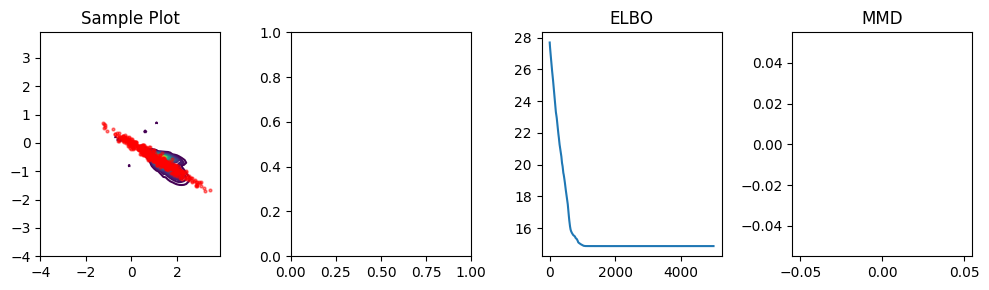

In [324]:
noise = np.random.normal(size=[500, 2])
P = g.get_density(obs,np.repeat([data[DATA_OF_INTEREST][0]], len(obs), axis=0),data[DATA_OF_INTEREST][1])
P = P.reshape(len(xs),len(xs))
plt.clf()
fig,ax = plt.subplots(1, 4, figsize=(10, 3))
ax[0].contour(x1,x2,P,30)
vi.update(noise, np.repeat([data[DATA_OF_INTEREST][0]], 500, axis=0), data[DATA_OF_INTEREST][1], iteration=5000)
zs = vi.e2z(noise)
history = vi.get_history()
#fcn.clean_history()
ax[0].plot(zs[:,0],zs[:,1],'ro',markersize=2, alpha=.5)
ax[0].set_title('Sample Plot')
ax[2].plot(history['kl'])
ax[2].set_title('ELBO')
ax[3].plot(history['mmd'])
ax[3].set_title('MMD')
vi.clean_history()
fig.tight_layout()
plt.show()

In [325]:
model_comparison['RegularVI'] = [zs, history['kl']]

# Deep Variational Inference

In [326]:
class NormalizingFlowVI(VariationalInference):
    def get_name(self):
        return "NF"

    def _build_graph(self):

        with tf.variable_scope('is'):
            self.noise = tf.placeholder(tf.float32, shape=[None, self._latent_dim])
            self.partialx = tf.placeholder(tf.float32, shape=[None, self._obs_dim])
            self.mask = tf.placeholder(tf.float32, shape=[self._obs_dim])

            with tf.variable_scope('projector'):
                self.projected, self.logdet = planar_projector(self.noise, self._num_layer, self._latent_dim)

            self.trainable_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "is/projector")

            with tf.variable_scope('generator'):
                self.generated, _ = self._generator(self.projected, self._latent_dim)

            if self._obs_distrib == "Gaussian":
                with tf.variable_scope('gaussian'):
                    log_like = self._gaussian_log_likelihood(self.partialx * self.mask,
                                                             self.generated * self.mask,
                                                             self._obs_std)
            else:
                with tf.variable_scope('bernoulli'):
                    log_like = self._bernoulli_log_likelihood(self.partialx * self.mask,
                                                              self.generated * self.mask)

            self.log_like = log_like - tf.reduce_sum(tf.log(self._p_distribution.prob(self.projected)), axis=1)
            self.probs = tf.exp(-self.log_like)

            log_loss = self.log_like + self.logdet

            self._loss = tf.reduce_mean(log_loss)

In [327]:
tf.reset_default_graph()
nf = NormalizingFlowVI(LATENT_DIM, OBS_DIM, DECODER, num_layer=16, sklearn=False)
nf.load_pretrained(WEIGHTS)

INFO:tensorflow:Restoring parameters from weights/generator.tensorflow


INFO:tensorflow:Restoring parameters from weights/generator.tensorflow


Loss: 13.5640: 100%|██████████| 10000/10000 [02:50<00:00, 58.77it/s]


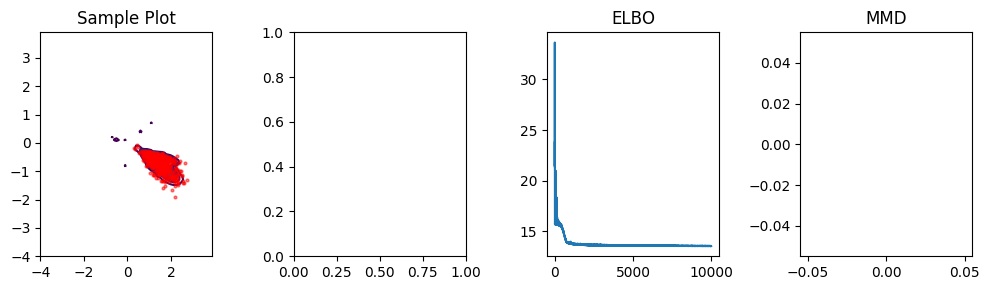

In [328]:
plt.clf()
noise = np.random.normal(size=[500, 2])
P = g.get_density(obs,np.repeat([data[DATA_OF_INTEREST][0]], len(obs), axis=0),data[DATA_OF_INTEREST][1])
P = P.reshape(len(xs),len(xs))
plt.clf()
fig,ax = plt.subplots(1, 4, figsize=(10, 3))
ax[0].contour(x1,x2,P,30)
nf.update(noise, np.repeat([data[DATA_OF_INTEREST][0]], 500, axis=0), data[DATA_OF_INTEREST][1],iteration=10000)
zs = nf.e2z(noise)
history = nf.get_history()
#fcn.clean_history()
ax[0].plot(zs[:,0],zs[:,1],'ro',markersize=2, alpha=.5)
ax[0].set_title('Sample Plot')
ax[2].plot(history['kl'])
ax[2].set_title('ELBO')
ax[3].plot(history['mmd'])
ax[3].set_title('MMD')
nf.clean_history()
fig.tight_layout()
plt.show()

In [329]:
model_comparison['NF'] = [zs, history['kl']]

In [330]:
class FullyConnectedVI(VariationalInference):
    def get_name(self):
        return "FCN"

    def _build_graph(self):

        with tf.variable_scope('is'):
            self.noise = tf.placeholder(tf.float32, shape=[None, self._latent_dim])
            self.partialx = tf.placeholder(tf.float32, shape=[None, self._obs_dim])
            self.mask = tf.placeholder(tf.float32, shape=[self._obs_dim])

            with tf.variable_scope('projector'):
                self.projected = fc_noise_projector(self.noise, 1, self._latent_dim, activation=tf.tanh)
            with tf.variable_scope('log-det'):
                determinant = get_determinant(get_jacobian(self.projected, self.noise))
                self.logdet = -tf.log(determinant)

            self.trainable_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "is/projector")

            with tf.variable_scope('generator'):
                self.generated, _ = self._generator(self.projected, self._latent_dim)

            if self._obs_distrib == "Gaussian":
                with tf.variable_scope('gaussian'):
                    log_like = self._gaussian_log_likelihood(self.partialx * self.mask,
                                                             self.generated * self.mask,
                                                             self._obs_std)
            else:
                with tf.variable_scope('bernoulli'):
                    log_like = self._bernoulli_log_likelihood(self.partialx * self.mask,
                                                              self.generated * self.mask)

            self.log_like = log_like - tf.reduce_sum(tf.log(self._p_distribution.prob(self.projected)), axis=1)
            self.probs = tf.exp(-self.log_like)

            log_loss = self.log_like + self.logdet

            self._loss = tf.reduce_mean(log_loss)

In [331]:
tf.reset_default_graph()
fcn = FullyConnectedVI(LATENT_DIM, OBS_DIM, DECODER, sklearn=False)
fcn.load_pretrained(WEIGHTS)

INFO:tensorflow:Restoring parameters from weights/generator.tensorflow


INFO:tensorflow:Restoring parameters from weights/generator.tensorflow


Loss: 13.5702: 100%|██████████| 20000/20000 [01:05<00:00, 303.97it/s]


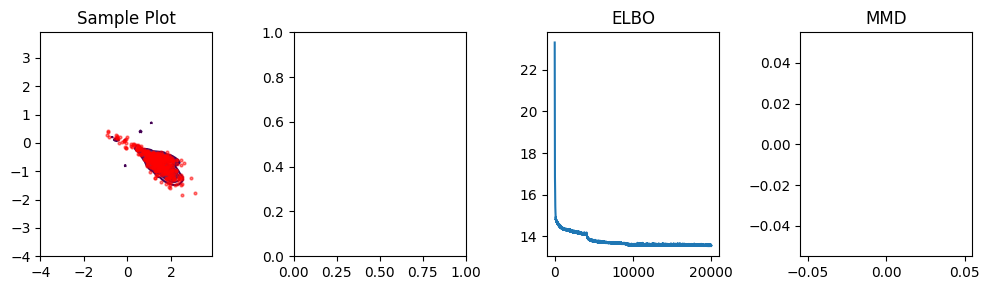

In [332]:
plt.clf()
noise = np.random.normal(size=[500, 2])
P = g.get_density(obs,np.repeat([data[DATA_OF_INTEREST][0]], len(obs), axis=0),data[DATA_OF_INTEREST][1])
P = P.reshape(len(xs),len(xs))
plt.clf()
fig,ax = plt.subplots(1, 4, figsize=(10, 3))
ax[0].contour(x1,x2,P,30)
fcn.update(noise, np.repeat([data[DATA_OF_INTEREST][0]], 500, axis=0), data[DATA_OF_INTEREST][1], iteration=20000)
zs = fcn.e2z(noise)
history = fcn.get_history()
#fcn.clean_history()
ax[0].plot(zs[:,0],zs[:,1],'ro',markersize=2, alpha=.5)
ax[0].set_title('Sample Plot')
ax[2].plot(history['kl'])
ax[2].set_title('ELBO')
ax[3].plot(history['mmd'])
ax[3].set_title('MMD')
fcn.clean_history()
fig.tight_layout()
plt.show()

In [333]:
model_comparison['DeepVI_FCN'] = [zs, history['kl']]

In [334]:
def make_movie_1(history, data_index):
    P = g.get_density(obs,np.repeat([data[data_index][0]], len(obs), axis=0),data[data_index][1])
    P = P.reshape(len(xs),len(xs))
    for i, sample in enumerate(history['sample']):
        if i%10 == 0:
            fig,ax = plt.subplots(1, 1, figsize=(4, 4))
            ax.contour(x1,x2,P,30)
            ax.plot(sample[:,0],sample[:,1],'ro',markersize=2, alpha=.5)
            ax.set_xlim(-2, 2)
            ax.set_ylim(-4, 2)
            fcn.clean_history()
            fig.tight_layout()
            plt.savefig('figures/{0}.png'.format(10000+i), format='png')

In [395]:
model_comparison = copy.deepcopy(model_comparison_backup)

In [356]:
model_comparison.keys()

['DeepVI_FCN', 'True', 'NF', 'RegularVI', 'HMC']

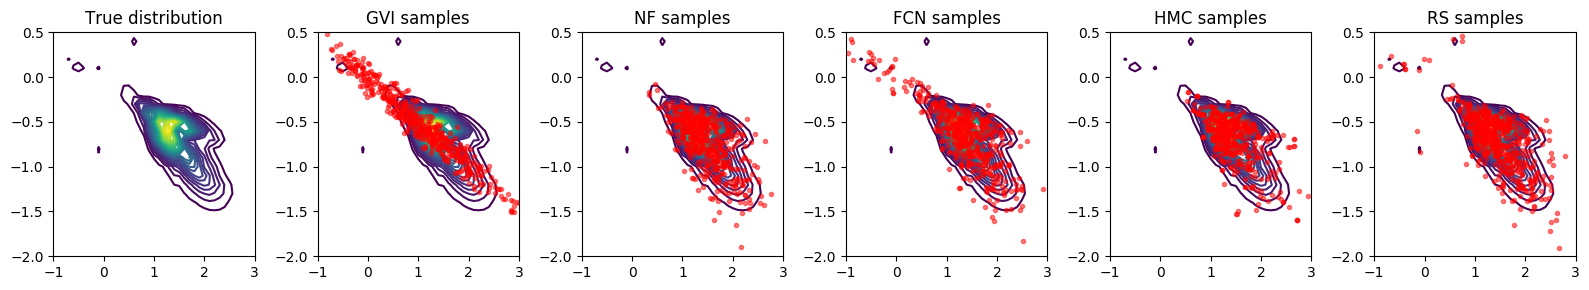

In [358]:
plt.clf()

def set_range(ax):
    h = 3 
    ax.set_xlim(-1.0, 3)
    ax.set_ylim(-2, 0.5)

xs = arange(-4,4,.1)
x1,x2 = meshgrid(xs,xs)
P = model_comparison['True'][0].reshape(len(xs),len(xs))
fig,ax = plt.subplots(1, 6, figsize=(16, 3))
keys = model_comparison.keys()
ax[0].contour(x1,x2,P,30)
ax[0].set_title('True distribution')
ax[5].contour(x1,x2,P,30)
ax[5].plot(model_comparison['True'][1][:,0],model_comparison['True'][1][:,1],'ro',markersize=3, alpha=.5)
ax[5].set_title('RS samples')
ax[4].contour(x1,x2,P,30)
ax[4].plot(model_comparison['HMC'][0][:,0],model_comparison['HMC'][0][:,1],'ro',markersize=3, alpha=.5)
ax[4].set_title('HMC samples')
keys.remove('True')
keys.remove('HMC')

keys = ['RegularVI', 'NF','DeepVI_FCN']

names = ['GVI', 'NF', 'FCN']

for i, key in enumerate(keys):
    ax[i+1].contour(x1,x2,P,30)
    ax[i+1].plot(model_comparison[key][0][:,0], 
                 model_comparison[key][0][:,1],
                 'ro',markersize=3, alpha=.5)
    ax[i+1].set_title(names[i]+' samples')
    
for i in range(6):
    set_range(ax[i])

plt.tight_layout()
plt.show()

In [365]:
keys = ['HMC', 'NF', 'DeepVI_FCN', 'RegularVI']

In [396]:
def show_mnist3(images, evidence, mask, row, col, 
                name="Unknown", save=True, folder='canvas', noise=True, exception=None):
    
    evidence[evidence < 0.5] = 0
    evidence[evidence >= 0.5] = 1
    positive = (evidence*mask).astype(bool).reshape(28,28)
    negative = ((1-evidence)*mask).astype(bool).reshape(28,28)
    num_images = row*col
    fig = plt.figure(figsize=(col, row))
    grid = ImageGrid(fig, 111,
                     nrows_ncols=(row, col),
                     axes_pad=0.01)
    for i in xrange(num_images):
        if noise == True and (i is not exception or exception is None):
            im = images[i]
            im[im < 0.5] = 0
            im[im >= 0.5] = 1
            im = im.reshape(28, 28)
            im = np.repeat(im[:, :, np.newaxis], 3, axis=2)
            #im[:,:,1][cond] = 0.5
            im[:,:,0][positive] = 1.0
            im[:,:,1][positive] = 0.6
            im[:,:,2][positive] = 0.2
            im[:,:,0][negative] = 0.0
            im[:,:,1][negative] = 0.0
            im[:,:,2][negative] = 0.7
            
        else:
            im = images[i].reshape(28, 28)
        axis = grid[i]
        axis.axis('off')
        axis.imshow(im, vmin=0, vmax=1)
    plt.axis('off')
    plt.tight_layout()
    if save:
        fig.savefig('figs/{0}/{1}.pdf'.format(folder, name), bbox_inches="tight", pad_inches=0, format='pdf')
        plt.show()
    else:
        plt.show()

500


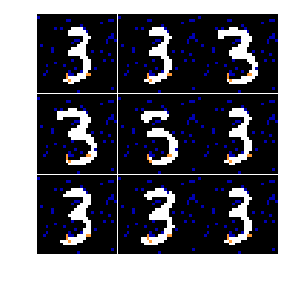

500


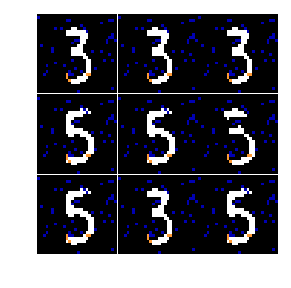

500


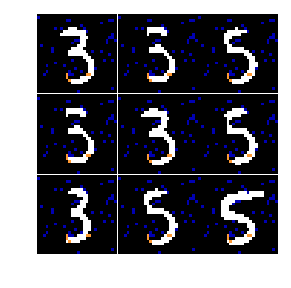

500


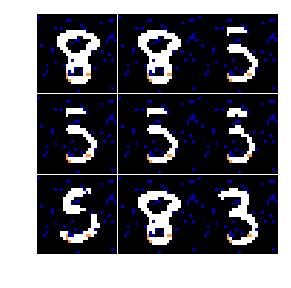

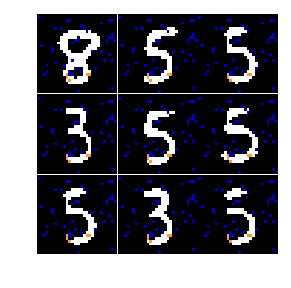

In [397]:
from random import shuffle
for key in keys:
    print len(model_comparison[key][0])
    z = model_comparison[key][0]
    shuffle(z)
    images = g.e2x(z)
    show_mnist3(images, data[DATA_OF_INTEREST][0], data[DATA_OF_INTEREST][1], 3, 3, save=False, noise=True, name=key, folder='samples')
images = g.e2x(model_comparison['True'][1])
show_mnist3(images, data[DATA_OF_INTEREST][0], data[DATA_OF_INTEREST][1], 3, 3, save=False, noise=True, name='reject', folder='samples')